<div style="text-align: center;">
    <h1>Classification Problems: SVM</h1>
    <h3>Mohammad Nourbakhsh Marvast</h3>
</div>

In [6]:
import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import confusion_matrix

#SVM Class using gradient descent:

In [177]:
class SVM:
  def __init__(self, learning_rate= 0.001, lambda_= 0.01, num_epochs= 1000):
    self.learning_rate = learning_rate
    self.lambda_ = lambda_
    self.num_epochs = num_epochs
    self.theta = None
    self.theta0 = None

  def fit(self, X_train, y_train):
    y_train = np.where(y_train <= 0, -1, 1)  #y_train \in \{-1,+1\}

    n, dim = X_train.shape
    self.theta = np.zeros(dim)
    self.theta0 = 0
    #self.learning_rate = self.learning_rate/n

    for _ in range(self.num_epochs):
      for i in range(n):

        y_i = np.dot(X_train[i], self.theta) + self.theta0
        update= self.learning_rate if y_train[i] * y_i < 1 else 0

        self.theta -= 2 * self.learning_rate * self.lambda_ * self.theta - update * y_train[i] * X_train[i]
        self.theta0 += update * y_train[i]

    #print("theta: ", self.theta)
    #print("theta0: ", self.theta0)

  def predict(self, X_test):
    linear_output = np.matmul(X_test, self.theta) + self.theta0
    y_pred = np.sign(linear_output)
    #print(y_pred)
    return y_pred


SVM classification accuracy 1.0


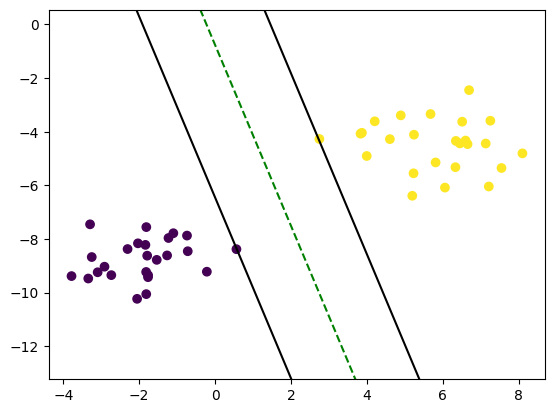

In [178]:
# Testing
if __name__ == "__main__":
    # Imports
    from sklearn.model_selection import train_test_split
    from sklearn import datasets
    import matplotlib.pyplot as plt

    X, y = datasets.make_blobs(
        n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40
    )
    y = np.where(y == 0, -1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )

    clf = SVM()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    print("SVM classification accuracy", accuracy(y_test, predictions))

    def visualize_svm():
        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x - b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])

        x1_1 = get_hyperplane_value(x0_1, clf.theta, clf.theta0, 0)
        x1_2 = get_hyperplane_value(x0_2, clf.theta, clf.theta0, 0)

        x1_1_m = get_hyperplane_value(x0_1, clf.theta, clf.theta0, -1)
        x1_2_m = get_hyperplane_value(x0_2, clf.theta, clf.theta0, -1)

        x1_1_p = get_hyperplane_value(x0_1, clf.theta, clf.theta0, 1)
        x1_2_p = get_hyperplane_value(x0_2, clf.theta, clf.theta0, 1)

        ax.plot([x0_1, x0_2], [x1_1, x1_2], "g--")
        ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
        ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

        x1_min = np.amin(X[:, 1])
        x1_max = np.amax(X[:, 1])
        ax.set_ylim([x1_min - 3, x1_max + 3])

        plt.show()

    visualize_svm()

## Cancer Dataset:

In [179]:
from sklearn.datasets import load_breast_cancer

In [180]:
# Load dataset
data_frame = load_breast_cancer()
data = data_frame.data
target = data_frame.target

In [181]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [182]:
clf = SVM()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

SVM accuracy:  0.9824561403508771


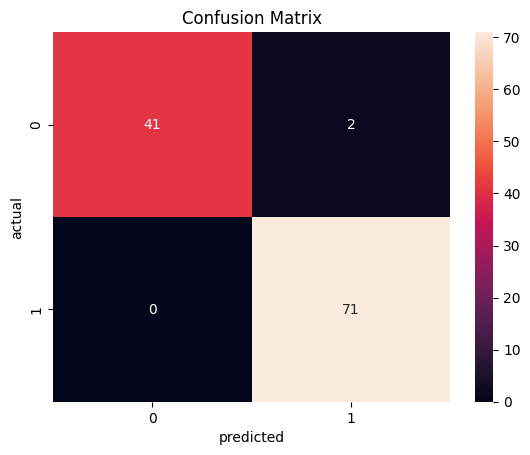

In [183]:
cmt = confusion_matrix(np.where(y_test <=0,-1,1), y_pred)
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("SVM accuracy: ", acc)
plt.figure()
sns.heatmap(cmt, annot=True, fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("predicted");
plt.ylabel("actual")
plt.show()

# Kernel SVM Class using Optimization:

In [184]:
import cvxopt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [185]:
def rbf_kernel(gamma, **kwargs):
  def f(x1, x2):
    distance = np.linalg.norm(x1 - x2) ** 2
    return np.exp(-gamma * distance)
  return f

In [247]:
class SupportVectorMachine(object):
  def __init__(self, C=1, kernel=rbf_kernel, power=4, gamma=None):
    self.C = C
    self.kernel = kernel
    self.power = power
    self.gamma = gamma
    self.lagr_multipliers = None
    self.support_vectors = None
    self.support_vector_labels = None
    self.intercept = None

  def fit(self, X, y):
    n_samples, n_features = np.shape(X)

    #y = np.where(y <= 0, -1, 1)

    if not self.gamma:
      self.gamma = 1 / n_features

    self.kernel = self.kernel(gamma=self.gamma)

    kernel_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
      for j in range(n_samples):
        kernel_matrix[i, j] = self.kernel(X[i],X[j])

    P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1, n_samples), tc='d')
    b = cvxopt.matrix(0, tc='d')

    if not self.C: #if its empty
      G = cvxopt.matrix(np.identity(n_samples) * -1)
      h = cvxopt.matrix(np.zeros(n_samples))

    else:
      G_max = np.identity(n_samples) * -1
      G_min = np.identity(n_samples)
      G = cvxopt.matrix(np.vstack((G_max, G_min)))
      h_max = cvxopt.matrix(np.zeros(n_samples))
      h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
      h = cvxopt.matrix(np.vstack((h_max, h_min)))

    minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

    lagr_mult = np.ravel(minimization['x'])

    # Get indexes of non-zero lagr. multipiers
    idx = lagr_mult > 1e-11

    # Get the corresponding lagr. multipliers
    self.lagr_multipliers = lagr_mult[idx]

    # Get the samples that will act as support vectors
    self.support_vectors = X[idx]

    # Get the corresponding labels
    self.support_vector_labels = y[idx]

    self.intercept = self.support_vector_labels[0]

    for i in range(len(self.lagr_multipliers)):
      self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

  def predict(self, X):
    y_pred = []
    for sample in X:
      prediction = 0
      # Determine the label of the sample by the support vectors
      for i in range(len(self.lagr_multipliers)):
        prediction += self.lagr_multipliers[i] * self.support_vector_labels[i] * self.kernel(self.support_vectors[i], sample)

      prediction += self.intercept
      y_pred.append(np.sign(prediction))
    return np.array(y_pred)


## Cancer Dataset:

In [187]:
from sklearn.datasets import load_breast_cancer

In [242]:
def linear_kernel(gamma, **kwargs):
  def f(x1,x2):
    return np.dot(x1,x2)
  return f

In [243]:
# Load dataset
data_frame = load_breast_cancer()
data = data_frame.data
target = data_frame.target

In [248]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.where(y_train <= 0, -1, 1)
y_test = np.where(y_test <= 0, -1, 1)

In [251]:
clf = SupportVectorMachine()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

     pcost       dcost       gap    pres   dres
 0: -5.4164e+01 -8.5860e+02  4e+03  2e+00  2e-15
 1: -3.5302e+01 -4.6314e+02  6e+02  2e-01  1e-15
 2: -3.5170e+01 -1.0836e+02  8e+01  2e-02  2e-15
 3: -4.3718e+01 -6.8508e+01  3e+01  5e-03  1e-15
 4: -4.7943e+01 -5.7659e+01  1e+01  1e-03  1e-15
 5: -5.0107e+01 -5.2839e+01  3e+00  1e-04  1e-15
 6: -5.0970e+01 -5.1359e+01  4e-01  1e-05  1e-15
 7: -5.1121e+01 -5.1132e+01  1e-02  2e-07  1e-15
 8: -5.1125e+01 -5.1125e+01  2e-04  3e-09  1e-15
 9: -5.1125e+01 -5.1125e+01  3e-06  3e-11  1e-15
Optimal solution found.


SVM accuracy:  0.9736842105263158


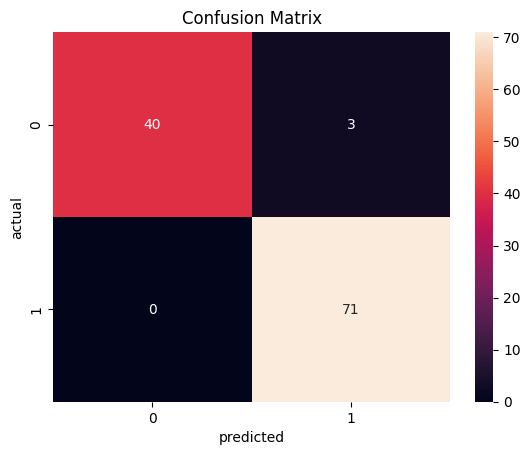

In [252]:
cmt = confusion_matrix(y_test, y_pred)
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("SVM accuracy: ", acc)
plt.figure()
sns.heatmap(cmt, annot=True, fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("predicted");
plt.ylabel("actual")
plt.show()

## Iris Dataset:

In [253]:
from sklearn.datasets import load_iris

In [255]:
data_frame = load_iris()
data = data_frame.data
target = data_frame.target

In [258]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

y_train0 = np.where(y_train == 0, -1, 1)
y_test0 = np.where(y_test == 0, -1, 1)
y_train1 = np.where(y_train == 1, -1, 1)
y_test1 = np.where(y_test == 1, -1, 1)
y_train2 = np.where(y_train == 2, -1, 1)
y_test2 = np.where(y_test == 2, -1, 1)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [259]:
clf = SupportVectorMachine(kernel=rbf_kernel, gamma = 1)
clf.fit(X_train, y_train0)
y_pred0 = clf.predict(X_test)


clf = SupportVectorMachine(kernel=rbf_kernel, gamma = 1)
clf.fit(X_train, y_train1)
y_pred1 = clf.predict(X_test)


clf = SupportVectorMachine(kernel=rbf_kernel, gamma = 1)
clf.fit(X_train, y_train2)
y_pred2 = clf.predict(X_test)


     pcost       dcost       gap    pres   dres
 0: -4.1021e+00 -1.4991e+02  5e+02  1e+00  4e-16
 1: -1.6334e+00 -5.9611e+01  6e+01  6e-16  5e-16
 2: -5.1662e+00 -1.1099e+01  6e+00  5e-16  6e-16
 3: -5.7834e+00 -7.4119e+00  2e+00  5e-16  3e-16
 4: -6.1024e+00 -6.4665e+00  4e-01  4e-16  3e-16
 5: -6.1865e+00 -6.2791e+00  9e-02  2e-16  3e-16
 6: -6.2113e+00 -6.2312e+00  2e-02  4e-16  3e-16
 7: -6.2181e+00 -6.2187e+00  6e-04  7e-16  3e-16
 8: -6.2184e+00 -6.2184e+00  1e-05  4e-16  4e-16
 9: -6.2184e+00 -6.2184e+00  1e-07  4e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5446e+01 -1.9416e+02  7e+02  2e+00  6e-16
 1: -1.1038e+01 -9.6720e+01  9e+01  1e-15  6e-16
 2: -1.5921e+01 -2.9959e+01  1e+01  9e-16  6e-16
 3: -1.8257e+01 -2.2121e+01  4e+00  4e-16  6e-16
 4: -1.8882e+01 -1.9888e+01  1e+00  4e-16  5e-16
 5: -1.9120e+01 -1.9337e+01  2e-01  2e-16  6e-16
 6: -1.9179e+01 -1.9201e+01  2e-02  1e-15  5e-16
 7: -1.9187e+01 -1.9187e+01  4e-04  4e-16  6e-1

In [262]:
y_pred = np.zeros(len(y_pred0))
y_pred[y_pred0 == -1] = 0
y_pred[y_pred1 == -1] = 1
y_pred[y_pred2 == -1] = 2

percepton accuracy:  1.0


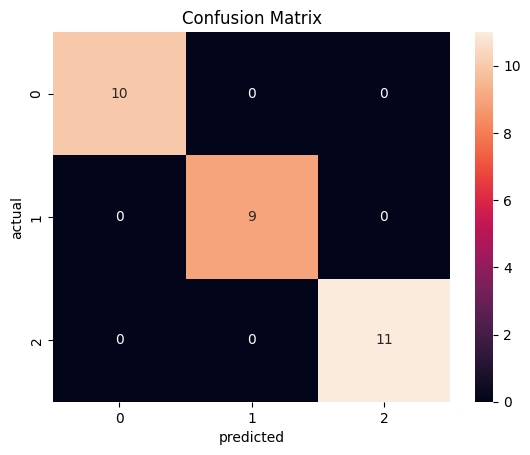

In [263]:
cmt = confusion_matrix(y_test, y_pred)
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("percepton accuracy: ", acc)

plt.figure()
sns.heatmap(cmt, annot=True, fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("predicted");
plt.ylabel("actual")
plt.show()

In [ ]:
from sklearn.datasets import load_wine

In [ ]:
# Load dataset
data_frame = load_wine()
data = data_frame.data
target = data_frame.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

y_train0 = np.where(y_train == 0, 0, 1)
y_train1 = np.where(y_train == 1, 0, 1)
y_train2 = np.where(y_train == 2, 0, 1)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
clf = perceptron(num_epochs=3, eta = 0.001)
clf.fit(X_train, y_train0)
y_pred0 = clf.predict(X_test)

clf.fit(X_train, y_train1)
y_pred1 = clf.predict(X_test)

clf.fit(X_train, y_train2)
y_pred2 = clf.predict(X_test)

In [ ]:
y_pred = np.zeros(len(y_pred0))
y_pred[y_pred0 == 0] = 0
y_pred[y_pred1 == 0] = 1
y_pred[y_pred2 == 0] = 2

In [ ]:
cmt = confusion_matrix(y_test, y_pred)
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("percepton accuracy: ", acc)

percepton accuracy:  1.0


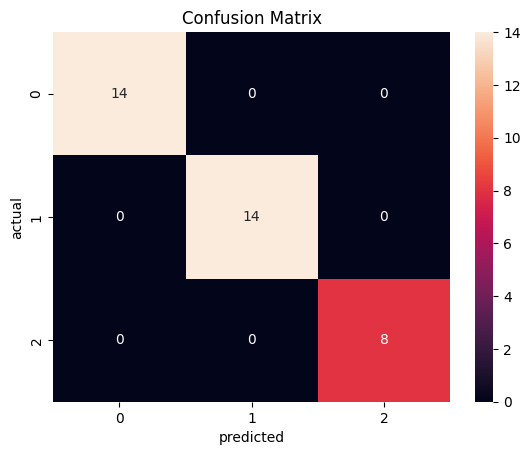

In [ ]:
plt.figure()
sns.heatmap(cmt, annot=True, fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("predicted");
plt.ylabel("actual")
plt.show()

## Wine Dataset

In [264]:
from sklearn.datasets import load_wine

In [267]:
# Load dataset
data_frame = load_wine()
data = data_frame.data
target = data_frame.target

In [268]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

y_train0 = np.where(y_train == 0, -1, 1)
y_test0 = np.where(y_test == 0, -1, 1)
y_train1 = np.where(y_train == 1, -1, 1)
y_test1 = np.where(y_test == 1, -1, 1)
y_train2 = np.where(y_train == 2, -1, 1)
y_test2 = np.where(y_test == 2, -1, 1)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [269]:
clf = SupportVectorMachine()
clf.fit(X_train, y_train0)
y_pred0 = clf.predict(X_test)

clf = SupportVectorMachine()
clf.fit(X_train, y_train1)
y_pred1 = clf.predict(X_test)

clf = SupportVectorMachine()
clf.fit(X_train, y_train2)
y_pred2 = clf.predict(X_test)

     pcost       dcost       gap    pres   dres
 0: -8.5817e+00 -1.9749e+02  7e+02  2e+00  6e-16
 1: -4.3545e+00 -8.6385e+01  9e+01  2e-02  7e-16
 2: -8.4139e+00 -2.3824e+01  2e+01  3e-03  6e-16
 3: -1.0219e+01 -1.3818e+01  4e+00  5e-04  5e-16
 4: -1.0892e+01 -1.1944e+01  1e+00  1e-04  5e-16
 5: -1.1156e+01 -1.1319e+01  2e-01  2e-16  5e-16
 6: -1.1208e+01 -1.1219e+01  1e-02  4e-16  5e-16
 7: -1.1212e+01 -1.1212e+01  5e-04  8e-16  5e-16
 8: -1.1212e+01 -1.1212e+01  1e-05  2e-16  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7260e+01 -2.1948e+02  7e+02  2e+00  6e-16
 1: -1.1850e+01 -1.0631e+02  9e+01  4e-16  6e-16
 2: -1.7189e+01 -3.1216e+01  1e+01  6e-16  6e-16
 3: -1.9662e+01 -2.4367e+01  5e+00  4e-16  5e-16
 4: -2.0756e+01 -2.1366e+01  6e-01  9e-16  5e-16
 5: -2.0965e+01 -2.0993e+01  3e-02  2e-15  6e-16
 6: -2.0976e+01 -2.0977e+01  9e-04  2e-15  5e-16
 7: -2.0977e+01 -2.0977e+01  3e-05  6e-16  5e-16
 8: -2.0977e+01 -2.0977e+01  2e-06  6e-16  5e-1

In [270]:
y_pred = np.zeros(len(y_pred0))
y_pred[y_pred0 == -1] = 0
y_pred[y_pred1 == -1] = 1
y_pred[y_pred2 == -1] = 2

In [271]:
cmt = confusion_matrix(y_test, y_pred)
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("percepton accuracy: ", acc)

percepton accuracy:  1.0


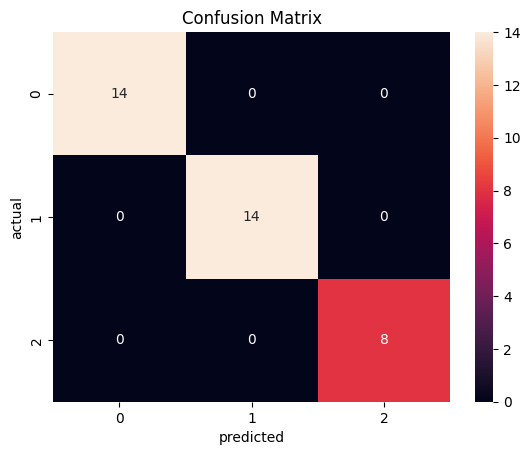

In [272]:
plt.figure()
sns.heatmap(cmt, annot=True, fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("predicted");
plt.ylabel("actual")
plt.show()